In [24]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import colors

In [2]:
# k_stiff = np.array([1, 1])
# k_soft = np.array([1, 0.0001])
# thresh = np.array([40, 20])
# theta_ss = np.array([20, 20])
# init_buckle = np.array([1, 1])
# desired_buckle = np.array([-1, -1])
k_stiff = np.array([2.0, 1.0])
k_soft = np.array([0.5, 0.1])
thresh = np.array([25, 8])
theta_ss = np.array([10, 10])
init_buckle = np.array([-1, 1])
desired_buckle = np.array([1, -1])

supress_prints = False

In [3]:
iterations = 80
alpha = 0.05

In [4]:
## Classes

class VariablesClass:
    """
    Class with variables dictated by supervisor
    """
    def __init__(self, k_stiff, k_soft, thresh, theta_ss):
        self.k_stiff = k_stiff
        self.k_soft = k_soft
        self.thresh = thresh
        self.theta_ss = theta_ss
        self.N_springs = np.size(k_stiff)
        
        # correct for un-physical threshold to move shim
        self.thresh[self.thresh<self.theta_ss] = self.theta_ss[self.thresh<self.theta_ss]
        
        # soft always 
        self.k_soft[self.k_soft>self.k_stiff] = self.k_stiff[self.k_soft>self.k_stiff]
    
    def set_normalizations(self, k_stiff, k_soft, theta_ss):
        self.k_bar = np.mean([np.mean(k_stiff), np.mean(k_soft)])
        self.theta_bar = np.mean(theta_ss)

        
class SupervisorClass:
    """
    Class with variables dictated by supervisor
    """
    def __init__(self, desired_buckle, alpha):
        self.desired_buckle = desired_buckle
        self.input_in_t = []
        self.input_update_in_t = []
        self.loss_in_t = []
        self.loss_MSE_in_t = []
        self.alpha = alpha
        
        self.input_update = 0
        self.input_update_in_t.append(self.input_update)
        
    def init_dataset(self, iterations):
        self.iterations = iterations
        # self.theta_vec = np.array([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50])
        self.theta_vec = np.random.uniform(-90, 90, iterations)
    
    def desired_tau(self):
        self.desired_tau_vec = np.zeros(np.size(self.theta_vec))
        for i, theta in enumerate(self.theta_vec):
            self.desired_tau_vec[i] = tau(theta, self.desired_buckle, Variabs)
            
    def set_theta(self, iteration):
        self.theta = self.theta_vec[iteration]
        self.desired_tau = self.desired_tau_vec[i]
        
    def calc_loss(self, tau):
        self.loss = loss(self.desired_tau, tau)
        self.loss_MSE = loss_MSE(self.loss)
        self.loss_in_t.append(self.loss)
        self.loss_MSE_in_t.append(self.loss_MSE)
        if not supress_prints:
            print('desired tau ', self.desired_tau)
            print('loss ', self.loss)
            print('MSE loss ', self.loss_MSE)
        
    def calc_input_update(self, State, Supervisor, Variabs):
        delta_theta = input_update(State.tau, Supervisor.loss, Supervisor.theta, Variabs.k_bar, Variabs.theta_bar)
        input_update_nxt = copy.copy(self.input_update) + self.alpha * delta_theta
        self.input_update = input_update_nxt
        self.input_update_in_t.append(self.input_update)
        if not supress_prints:
            print('input_update ', self.input_update)


class StateClass:
    """
    Class with state variables
    """
    def __init__(self, Variabs, Supervisor, buckle=None):
        # self.buckle_in_t = np.zeros([Supervisor.iterations, Variabs.N_springs])
        # self.tau_in_t = np.zeros(Supervisor.iterations)
        self.buckle_in_t = []
        self.tau_in_t = []
        
        if buckle is not None:
            self.buckle = buckle
        else:
            self.buckle = np.ones(Variabs.N_springs)
        if not supress_prints:
            print('buckle pattern ', self.buckle)
        self.buckle_in_t.append(self.buckle)

    def calc_tau(self, theta, Variabs):
        self.tau = tau(theta, self.buckle, Variabs) 
        if not supress_prints:
            print('tau ', self.tau)
            
    def evolve_material(self, Supervisor, Variabs):
        buckle_nxt = np.zeros(Variabs.N_springs)
        for i in range(Variabs.N_springs):
            if self.buckle[i] == 1 and Supervisor.input_update > Variabs.thresh[i]:  # buckle left
                buckle_nxt[i] = -1
            elif self.buckle[i] == -1 and Supervisor.input_update < -Variabs.thresh[i]:  # buckle right
                buckle_nxt[i] = 1
            else:
                buckle_nxt[i] = self.buckle[i]
        self.buckle = copy.copy(buckle_nxt)
        self.buckle_in_t.append(self.buckle)
        if not supress_prints:
            print('buckle pattern ', self.buckle)

In [5]:
def tau(theta, buckle, Variabs):
    return np.sum(tau_k(theta, buckle, Variabs))
    

def tau_k(theta, buckle, Variabs):
    tau_k = np.zeros(Variabs.N_springs)
    for i in range(Variabs.N_springs):
        if buckle[i] == 1 and theta > -Variabs.theta_ss[i] or buckle[i] == -1 and theta > Variabs.theta_ss[i]:
            k = Variabs.k_stiff[i]
        else:
            k = Variabs.k_soft[i]
        tau_k[i] = -k * (theta - (-buckle[i]) * Variabs.theta_ss[i])
    return tau_k


def loss(tau, desired_tau):
    return desired_tau - tau


def loss_MSE(loss):
    return np.mean(loss**2)


def input_update(tau, loss, theta, k_bar, theta_bar):
    return (tau/k_bar-theta)*(loss)/(k_bar*theta_bar)

In [6]:
Variabs = VariablesClass(k_stiff, k_soft, thresh, theta_ss)
Variabs.set_normalizations(k_stiff, k_soft, theta_ss)

In [7]:
Supervisor = SupervisorClass(desired_buckle, alpha)
Supervisor.init_dataset(iterations)
Supervisor.desired_tau()

In [8]:
State = StateClass(Variabs, Supervisor, buckle=init_buckle)

buckle pattern  [-1  1]


## Loop

In [9]:
for i in range(iterations):
    
    ## Measure
    Supervisor.set_theta(i)
    State.calc_tau(Supervisor.theta, Variabs)
    
    ## Loss
    Supervisor.calc_loss(State.tau)
    
    ## Update
    Supervisor.calc_input_update(State, Supervisor, Variabs)
    State.calc_tau(Supervisor.input_update, Variabs)
    State.evolve_material(Supervisor, Variabs)

tau  -223.8832092013282
desired tau  -243.8832092013282
loss  20.0
MSE loss  400.0
input_update  -36.30224345206503
tau  25.781346071239017
buckle pattern  [1. 1.]
tau  47.71408086271846
desired tau  49.71408086271846
loss  -2.0
MSE loss  4.0
input_update  -37.88601137992671
tau  16.731606827956025
buckle pattern  [1. 1.]
tau  -214.45994219048129
desired tau  -194.45994219048129
loss  -20.0
MSE loss  400.0
input_update  -4.577625596269215
tau  -16.267123211192356
buckle pattern  [1. 1.]
tau  -190.96001987617274
desired tau  -170.96001987617274
loss  -20.0
MSE loss  400.0
input_update  24.959167717190603
tau  -104.8775031515718
buckle pattern  [ 1. -1.]
tau  -26.426188901660904
desired tau  -26.426188901660904
loss  0.0
MSE loss  0.0
input_update  24.959167717190603
tau  -84.8775031515718
buckle pattern  [ 1. -1.]
tau  -257.2187195355573
desired tau  -257.2187195355573
loss  0.0
MSE loss  0.0
input_update  24.959167717190603
tau  -84.8775031515718
buckle pattern  [ 1. -1.]
tau  49.52187

In [22]:
np.asarray(State.buckle_in_t)[:,0]

array([-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.])

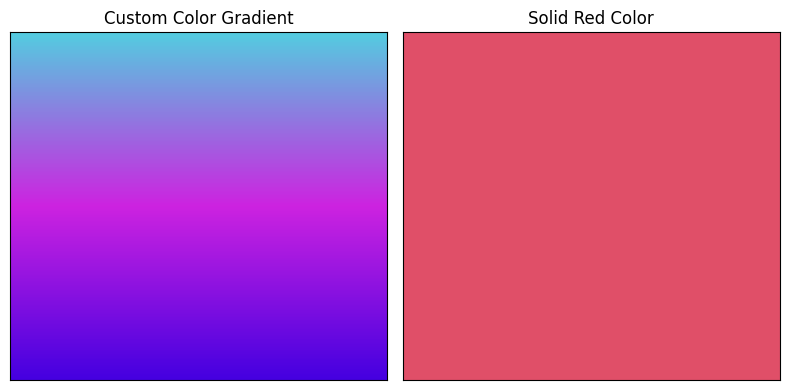

In [29]:
# Set the custom color cycle globally without cycler
colors_lst, red, custom_cmap = colors.color_scheme(show=True)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', colors_lst)

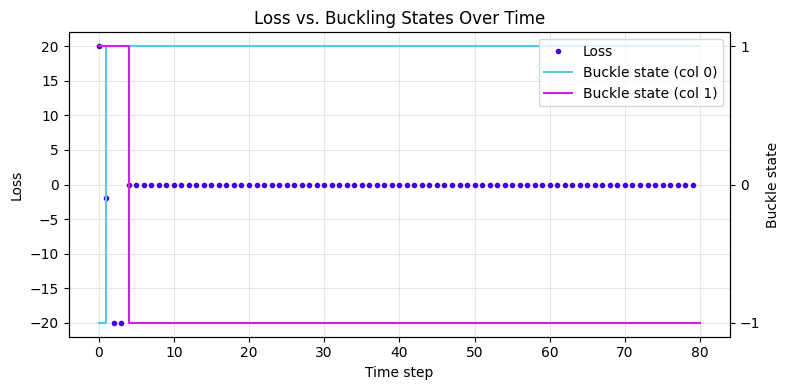

In [41]:
fig, ax1 = plt.subplots(figsize=(8,4))

# Set the custom color cycle globally without cycler
colors_lst, red, custom_cmap = colors.color_scheme()
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', colors_lst)

buckle_in_t = np.asarray(State.buckle_in_t)

# Plot Supervisor loss on left y-axis
ax1.plot(Supervisor.loss_in_t, '.', lw=2, label="Loss")
ax1.set_xlabel("Time step")
ax1.set_ylabel("Loss")
ax1.tick_params(axis="y")

# Second y-axis for buckling state
ax2 = ax1.twinx()
ax2.step(np.arange(buckle_in_t.shape[0]), 
         buckle_in_t[:,0], where="post", color = colors_lst[1],
         lw=1.5, label="Buckle state (col 0)")
ax2.step(np.arange(buckle_in_t.shape[0]), 
         buckle_in_t[:,1], where="post", color = colors_lst[2],
         lw=1.5, label="Buckle state (col 1)")
ax2.set_ylabel("Buckle state")
ax2.tick_params(axis="y")
ax2.set_yticks([-1, 0, 1])

# Add grid, legend, and title
ax1.grid(alpha=0.3)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Loss vs. Buckling States Over Time")

plt.tight_layout()
plt.show()


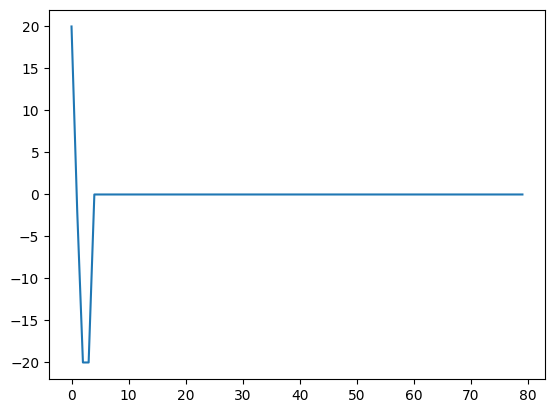

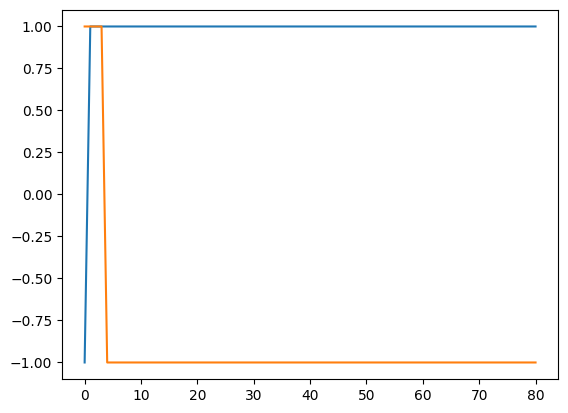

In [10]:
plt.plot(Supervisor.loss_in_t)
plt.show()

plt.plot(State.buckle_in_t)